In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
#combine all exported txt files from Whatsapp into one txt
filenames = ['file1.txt', 'file2.txt', ...]
with open('path/to/output/file', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())

"\n#General code to combine all exported txt files into one\nfilenames = ['file1.txt', 'file2.txt', ...]\nwith open('path/to/output/file', 'w') as outfile:\n    for fname in filenames:\n        with open(fname) as infile:\n            outfile.write(infile.read())\n"

In [45]:
df = pd.read_fwf('compiled_file.txt')

In [46]:
'''
Exported file from WhatsApp looks as following:
+------------+------------+------------+
|   Message  | Unnamed: 1 | Unnamed: 2 |
+------------+------------+------------+
| 'text_msg' |    NaN     |    NaN     | 
+------------+------------+------------+
'''
#drop two columns Unnamed columns with NaN data
df.drop('Unnamed: 1',axis=1,inplace=True)
df.drop('Unnamed: 2',axis=1,inplace=True)

In [47]:
#rename the working column
df.columns = ['Initial String']
'''
The exported message entry as a string has the general form as following:
[yyyy-mm-dd, h:mm:s AM/PM] Sender: Text of Message
Example:
[2020-01-01, 6:20:34 PM] John: Good morning!
'''

In [49]:
#check how many rows have blank values; blank values resign the return hit key in the message
#Example:
#This will
#result in NaN
df[df.isna().any(axis=1)] 

,Initial String
2873,NaN
2875,NaN
2877,NaN
3016,NaN
3113,NaN
...,...
43505,NaN
43508,NaN
43511,NaN
43514,NaN


In [50]:
#drop all NaN values from the dataframe
df.dropna(inplace=True)

In [51]:
#If return key was used to make new paragraph in one text message on WhatsApp
#the message got splitted into several rows
#Concatenate the rows that do not start with '[' to the closest row that starts with it. 
df = pd.DataFrame(data = df['Initial String'].groupby(df['Initial String'].str[0].eq('[').cumsum()).agg(' '.join))

In [52]:
#get the date and the time of a message by splitting the entry by ']' 
#and taking the first value from the list starting from second character to eliminate the first '['
df['DateTime'] = df[df.columns[0]].apply(lambda x:x.split('] ')[0][1:])

In [53]:
#get the message with the name of a sender
df['Message with sender'] = df[df.columns[0]].apply(lambda x:x.partition('] ')[2])

In [54]:
#remove sender's name
df['Message'] = df['Message with sender'].apply(lambda x:x.partition(":")[2])

In [56]:
#dropping the columns 
df.drop('Message with sender', axis = 1, inplace = True)
df.drop('Initial String', axis = 1, inplace = True)

In [57]:
#transform a string into datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [58]:
'''
Create the columns for Hour, Day of week, Month, Year
'''
df['Hour'] = df['DateTime'].apply(lambda x : x.hour)
df['Month'] = df['DateTime'].apply(lambda x : x.month)
df['Year'] = df['DateTime'].apply(lambda x : x.year)
df['Day of week'] = df['DateTime'].apply(lambda x : x.dayofweek)
df['Month_Year'] = pd.to_datetime(df['DateTime']).dt.to_period('M')

In [59]:
#Naming days of week through mapping a vocabulary
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['Day of week'] = df['Day of week'].map(dmap)

In [60]:
#save df to a csv file
df.to_csv(r'file1.csv',index = True)

In [61]:
#grouping df by months and years to create a month-annual trend
df1 = df.groupby('Month_Year').count().iloc[:,0]

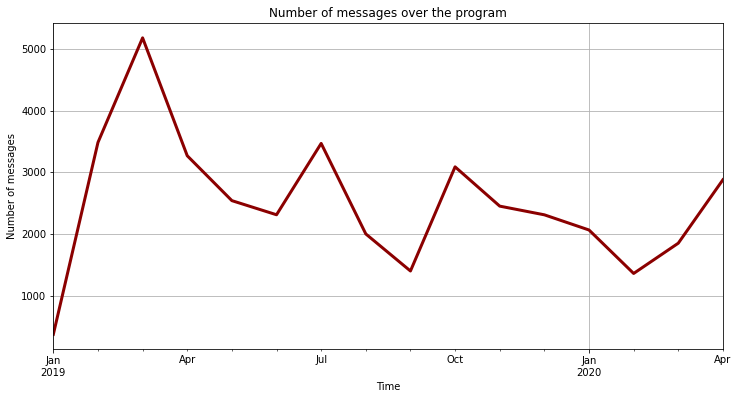

In [63]:
#create a trend graph counting the number of messages every month
df1.plot.line(figsize=(12,6),title = 'Number of messages over the program',color='darkred',lw=3)
plt.xlabel('Time')
plt.ylabel('Number of messages')
plt.grid()
plt.show()

In [64]:
#group by hour
df2 = df.groupby('Hour').count().iloc[:,0]

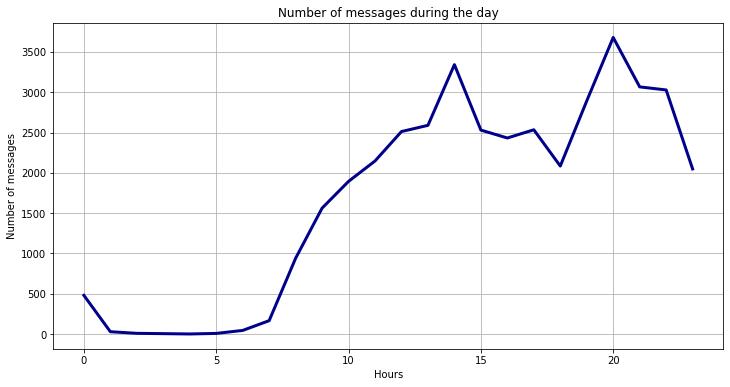

In [66]:
#create a plot for hour
df2.plot(figsize=(12,6),title = 'Number of messages during the day',color='darkblue',lw=3)
plt.xlabel('Hours')
plt.ylabel('Number of messages')
plt.grid()
plt.show()

In [67]:
#group by day of week
df3 = df.groupby('Day of week').count().iloc[:,0]

In [68]:
#correct order of day weeks
df3 = df3.reindex(['Mon', 'Tue', 'Wed', 'Thu','Fri','Sat','Sun'])

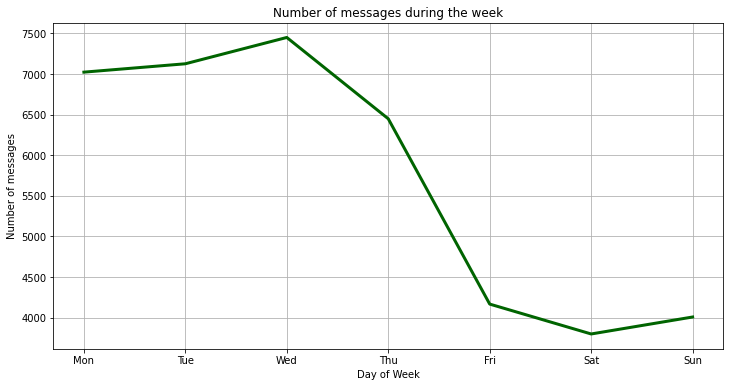

In [84]:
#create a plot for days of the week
df3.plot(figsize=(12,6),title = 'Number of messages during the week',color='darkgreen',lw=3)
plt.xlabel('Day of Week')
plt.ylabel('Number of messages')
plt.grid()
plt.show()

In [70]:
'''
The next steps are executed to pull out the most frequently used words
'''
#lowercase all messages
df['Message'] = df['Message'].str.lower()

In [71]:
#remove special characters from the strings to get the actual words
df['Message'] = df['Message'].str.strip('. ! ? ; , : !! !!! !!! ( ) +')

In [72]:
#split the messages the list of words
df['Message'] = df['Message'].str.split()

In [73]:
#transforms each element of the list into a new row 
df_w = df.explode('Message') #assign to a new df to work with words

In [74]:
#create a list of words that should be omitted
om_l = ['list of common verbs, adverbs, pronouns etc.']

In [75]:
#transform df into the one that does not have the items in the list above
df_w = df_w.loc[~df_w['Message'].isin(om_l)]

In [76]:
#group by the values by month and year that counts each instance of a word
df_w = df_w.groupby('Month_Year')['Message'].value_counts()

In [77]:
#show the most frequently used word monthly in multilevel series
df_w = df_w.groupby('Month_Year').head(1)

In [78]:
df_w = pd.DataFrame(data=df_w) #cast seties into dataframe to save
df_w.columns = ['Msg_count'] #rename the column

In [80]:
#save dataframe with top 1 words to a csv file 
df_w.to_csv(r'filename.csv',index = True)